# 01 – Exploratory Data Analysis  
## Competitive Workload & Risk Proxy

### Objective
This notebook explores the relationship between short-term competitive workload 
and a next-match risk proxy (`high_risk_next`).

This reflects a hybrid performance + data science approach combining:

- Reconstructed true match minutes
- Rolling workload exposure (7/14/28 days)
- ACWR (Acute:Chronic Workload Ratio)
- Forward-looking risk proxy

This is a methodological framework demonstration rather than a clinical injury model.


In [1]:
# === Setup ===
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    "figure.figsize": (9, 4),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def resolve_db_path():
    cwd = Path.cwd()
    candidates = [
        cwd / "lakehouse" / "analytics.duckdb",
        cwd.parent / "lakehouse" / "analytics.duckdb"
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("DuckDB file not found.")

DB_PATH = resolve_db_path()


In [2]:
# === Load Data ===
with duckdb.connect(str(DB_PATH)) as con:
    df = con.execute("SELECT * FROM player_dataset_final").df()
    dfp = con.execute("SELECT * FROM player_dataset_predictive WHERE acwr IS NOT NULL").df()

df.shape, dfp.shape


((97722, 22), (51569, 23))

## Minutes Distribution

Understanding competitive exposure baseline.


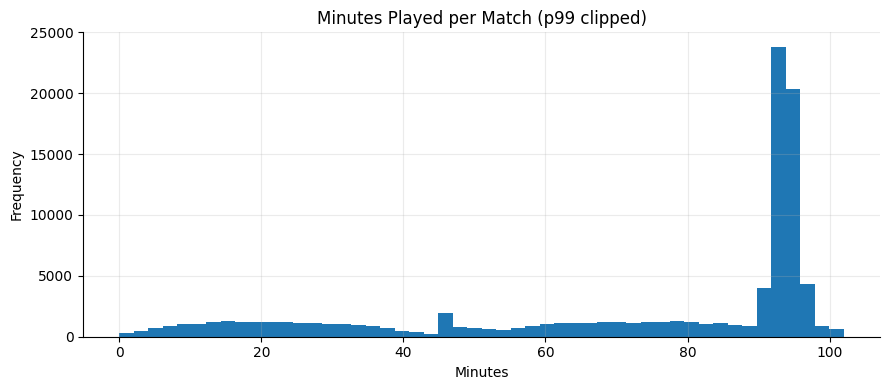

In [3]:
x = df["minutes"].dropna()
x_clip = x[x <= x.quantile(0.99)]

plt.hist(x_clip, bins=50)
plt.title("Minutes Played per Match (p99 clipped)")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## ACWR Distribution

Workload imbalance indicator distribution.


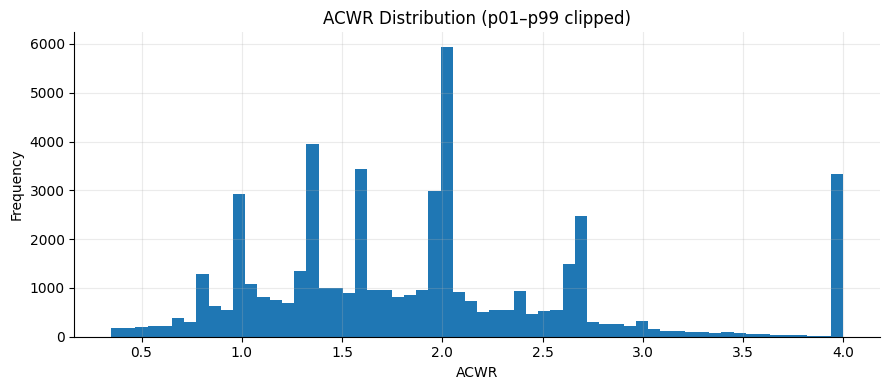

In [4]:
x = dfp["acwr"].dropna()
x_clip = x[(x >= x.quantile(0.01)) & (x <= x.quantile(0.99))]

plt.hist(x_clip, bins=60)
plt.title("ACWR Distribution (p01–p99 clipped)")
plt.xlabel("ACWR")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Risk vs 7-Day Workload
Assessing association between short-term congestion and risk proxy.


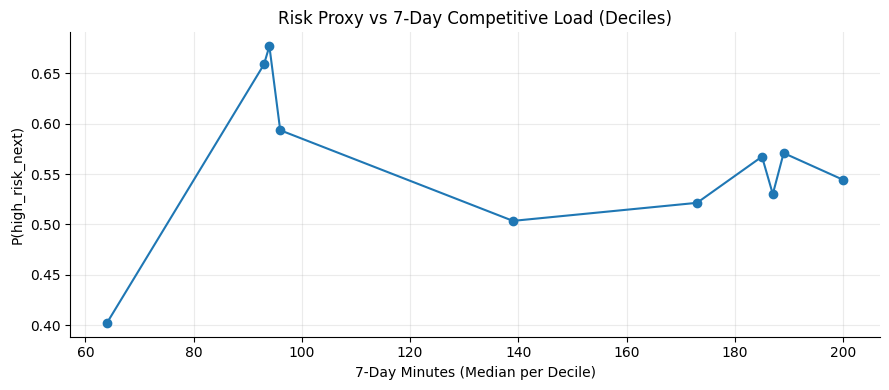

In [5]:
tmp = dfp.dropna(subset=["minutes_last_7d", "high_risk_next"]).copy()
tmp = tmp[tmp["minutes_last_7d"] <= tmp["minutes_last_7d"].quantile(0.99)]

tmp["bin"] = pd.qcut(tmp["minutes_last_7d"], q=10, duplicates="drop")

g = tmp.groupby("bin", observed=True).agg(
    median_load=("minutes_last_7d", "median"),
    risk=("high_risk_next", "mean")
).reset_index()

plt.plot(g["median_load"], g["risk"], marker="o")
plt.title("Risk Proxy vs 7-Day Competitive Load (Deciles)")
plt.xlabel("7-Day Minutes (Median per Decile)")
plt.ylabel("P(high_risk_next)")
plt.tight_layout()
plt.show()


## Interpretation

- Competitive congestion shows measurable association with risk proxy.
- Relationship appears non-linear.
- Competitive load alone provides partial signal.

Professional environments would integrate internal and GPS-derived load metrics.
